In [34]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
import ForwardDiff as FD

  Activating environment at `~/SSD/Code/TinyMPC/julia/aug_lag_lqr/Project.toml`


In [35]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.

function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ)
    """iLQR backward pass with AL. This !function update its parameters
    """
    println("backward pass")
    # backwards pass for Altro
    # P - vector of cost to go quadratic terms (matrices)
    # p - vector of cost to go linear terms (vectors)
    # K - vector of feedback gain matrices (matrices)
    # d - vector of feedforward controls (vectors)

    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N] = params.Qf 
    p[N] = Qf*X[N]
    # add AL terms for the state constraint at the final time step
#     hxv = ineq_con_x(params,X[N])  # h(x) violation  
#     mask = eval_mask(μx[N],hxv)
#     ∇hx = ineq_con_x_jac(params,X[N])

#     # add these into the cost-to-go p and P
#     p[N]  += ∇hx'*(μx[N] + ρ*(mask * hxv))  # multiplier term (1st)
#     P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)

#     # add AL terms for goal constraint 
#     hxv = X[N] - params.Xref[N]
#     ∇hx = diagm(ones(params.nx))

#     # add these into the CTG p and P (equality active)
#     p[N]  += ∇hx'*(λ + ρ*hxv)   
#     P[N]  += ρ*∇hx'∇hx

    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1

        # dynamics jacobians (linearization about previous iterate)
        A = FD.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = FD.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])
        # display(B)
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx = A' * (p[k+1]) + params.Q*X[k]
        Su = B' * (p[k+1]) + params.R*U[k]
        Sxx = params.Q + A'*(P[k+1])*A
        Suu = params.R + B'*(P[k+1] + 1*reg*I)*B                                     
        Sux = B'*(P[k+1])*A  

        # control constraints
        huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
        mask = eval_mask(μ[k],huv)  # choose active
        ∇hu = ineq_con_u_jac(params,U[k])
        Su  += ∇hu'*(μ[k] + ρ*(mask * huv)) # add to cost
        Suu += ρ*∇hu'*mask*∇hu

        # # state constraints
        # hxv = ineq_con_x(params,X[k])
        # mask = eval_mask(μx[k],hxv)
        # ∇hx = ineq_con_x_jac(params,X[k])
        # Jx  += ∇hx'*(μx[k] + ρ*(mask * hxv))
        # Jxx += ρ*∇hx'*mask*∇hx

        # Calculate Gains
        F = cholesky(Symmetric(Suu))
        d[k] = F\Su
        K[k] = F\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        # or P[k] = Gxx + K'GuuK - GxuK - K'Gux
        # P[k] = Jxx + K[k]'*Juu*K[k] + (A-B*K[k])'*P[k+1]*(A-B*K[k])
        # p[k] = Jx - K[k]'*Ju + K[k]'*Juu*d[k] + (A - B*K[k])'*(p[k+1] - P[k+1]*B*d[k])
        P[k] = Sxx + K[k]'*Suu*K[k] - K[k]'*Sux - Sux'*K[k]
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function trajectory_AL_cost(params,X,U,μ,μx,ρ,λ)
    """Calcuate total cost (AL) for the whole trajectory
    """
    N = params.N
    J = 0.0
    for k = 1:N-1
        J += stage_cost(params,X[k],U[k],k)

        # AL terms for ineq_con_u
        huv = ineq_con_u(params,U[k])
        mask = eval_mask(μ[k],huv)
        J += dot(μ[k],huv) + 0.5*ρ*huv'*mask*huv

        # AL terms for ineq_con_x
        hxv = ineq_con_x(params,X[k])
        mask = eval_mask(μx[k],hxv)
        J += dot(μx[k],hxv) + 0.5*ρ*hxv'*mask*hxv
    end

    # AL terms for state constraint at last time step
    # J += term_cost(params,X[N])
    # hxv = ineq_con_x(params,X[params.N])
    # mask = eval_mask(μx[params.N],hxv)
    # J += dot(μx[params.N],hxv) + 0.5*ρ*hxv'*mask*hxv

    # AL terms for goal constraint
    # hxv = X[N] - params.Xref[N]
    # J += dot(λ,hxv) + 0.5*ρ*hxv'*hxv
    return J
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; 
                        max_linesearch_iters = 20)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
    α = 1.0
    # previous cost
    J = trajectory_AL_cost(params,X,U,μ,μx,ρ,λ)
    for i = 1:1
    println("forward pass")
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = U[k] - α*d[k] - K[k]*(Xn[k]-X[k])  
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
        Jn = trajectory_AL_cost(params,Xn,Un,μ,μx,ρ,λ)  # new cost

        # backtracking linesearch (should use Armijo?)
        # if Jn < J
        #     # println("line search - better found")
            X .= Xn
            U .= Un
        #     return Jn, α
        # else
        #     α *= 0.5
        # end
    end

    # @warn "forward pass failed, adding regularization"
    # α = 0.0
    return J, α
end
function update_reg(reg,reg_min,reg_max,α)  
    # Update regularization parameter
    if α == 0.0  # if forward pass fails, enhance regularization
        if reg == reg_max
            error("reached max reg")
        end
        return min(reg_max,reg*10)
    end
    if α == 1.0  # if forward pass is perfect, lower regularization
        return max(reg_min,reg/10)
    end
    return reg
end
function calc_max_d(d)  
    # The feedforward gains go to zero. We compute the
    # average maximum of the normalized gains
    # Just calc the max absolute naively.
    dm = 0.0
    for i = 1:length(d)
        dm = max(dm,norm(d[i]))
    end
    return dm
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function iLQR(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters = 250,verbose = true,ρ=1,ϕ=10)

    # first check the sizes of everything
    @assert length(X) == params.N
    @assert length(U) == params.N-1
    @assert length(X[1]) == params.nx
    @assert length(U[1]) == params.nu
    @assert length(ineq_con_u(params,U[1])) == params.ncu  # no constraint control
    @assert length(ineq_con_x(params,X[1])) == params.ncx  # no constraint state

    # keep track of trajectories for each iterate
    Xhist=[deepcopy(X) for i = 1:1000]

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    Xhist[1] .= X


    reg_min = 1e-8
    reg = reg_min
    reg_max = 1e2

    μ = [zeros(params.ncu) for i = 1:N-1]   # input constraints

    μx = [zeros(params.ncx) for i = 1:N]    # state constraints

    λ = zeros(params.nx)    # goal constraint

    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters
        ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ)
        J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)

        Xhist[iter + 1] .= X

        # reg = update_reg(reg,reg_min,reg_max,α)
        dmax = calc_max_d(d)    
        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, dmax, α, reg, ρ)
        end

        # Iterate until inner loop converges (feasible linesearch and zero feedforward)
        # Then do outer update
        if (α > 0) & (dmax<atol) 
            println("update duals and penalty")
            # update multipliers and check constraint violation, max of all
            convio = 0  

            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual
                μ[k] = max.(0,μ[k] + ρ*mask*huv)
                convio = max(convio,norm(huv + abs.(huv),Inf))
            end

#             # state constraints (inequality)
#             for k = 1:N
#                 hxv = ineq_con_x(params,X[k])
#                 mask = eval_mask(μx[k],hxv)

#                 # update dual
#                 μx[k] = max.(0,μx[k] + ρ*mask*hxv)
#                 convio = max(convio,norm(hxv + abs.(hxv),Inf))
#             end

            # # goal constraint (equality)
            # hxv = X[N] - params.Xref[N]
            # λ .+= ρ*hxv
            # convio = max(convio, norm(hxv,Inf))

            @show convio
            println()
            if convio <1e-4  # if terminal condition with contraint violation
                @info "success!"
                return Xhist[1:(iter + 1)];
            end

            ρ *= ϕ  # update penalty
        end
    end
    error("iLQR failed")
end
#----------------------ALTRO DONE --------------------------

iLQR (generic function with 1 method)

In [36]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
function discrete_dynamics(p::NamedTuple,x,u,k)
    # RK4
    A = [1.0  0.0  0.1  0.0;
         0.0  1.0  0.0  0.1;
         0.0  0.0  1.0  0.0;
         0.0  0.0  0.0  1.0]
    B = [0.005  0.0;
         0.0    0.005;
         0.1    0.0;
         0.0    0.1]
    return A*x + B*u
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function ineq_con_u_jac(params,u)
    FD.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    FD.jacobian(_x -> ineq_con_x(p,_x),x)
end

ineq_con_x_jac (generic function with 1 method)

backward pass
forward pass
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    3.089e+02   2.75e+03   4.47e+01  1.0000    1.00e-08    1.00e+00
backward pass
forward pass
  2    1.065e+02   7.36e+01   4.95e+00  1.0000    1.00e-08    1.00e+00
backward pass
forward pass
  3    7.943e+01   1.68e+01   2.66e+00  1.0000    1.00e-08    1.00e+00
backward pass
forward pass
  4    7.149e+01   8.06e-01   7.90e-01  1.0000    1.00e-08    1.00e+00
backward pass
forward pass
  5    7.108e+01   9.76e-21   7.96e-11  1.0000    1.00e-08    1.00e+00
update duals and penalty
convio = 2.4480620500339576

backward pass
forward pass
  6    1.088e+02   6.44e+01   1.21e+00  1.0000    1.00e-08    1.00e+01
backward pass
forward pass
  7    1.003e+02   4.67e+01   1.75e+00  1.0000    1.00e-08    1.00e+01
backward pass
forward pass
  8    7.692e+01   4.24e-02   6.47e-02  1.0000    1.00e-08    1.00e+01
update duals and penalty
c

┌ Info: success!
└ @ Main In[35]:278


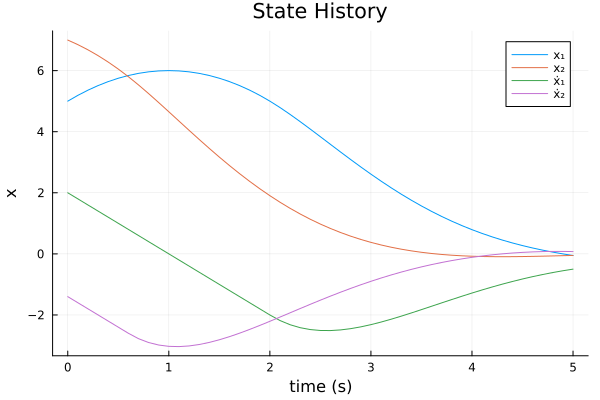

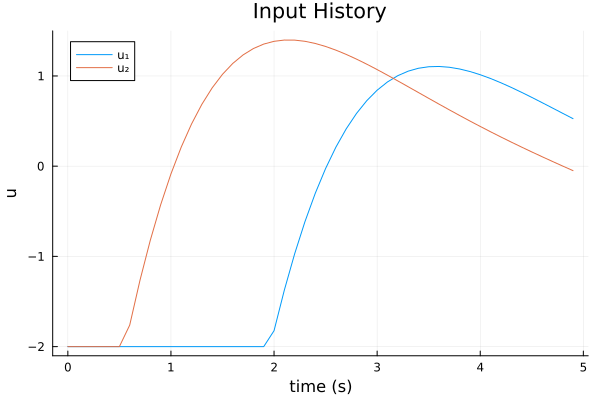

In [37]:
# Let's solve

nx = 4
nu = 2
N = 51
dt = 0.1
t_vec = dt*(0:N-1)
x0 = [5,7,2,-1.4]
xg = [0,0,0,0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]
Q = 1e-2*Diagonal([10,10,1,1.0])
R = 1e-1*Diagonal([1.0,1.0])
Qf = 100*Q

u_min = -2*ones(nu)
u_max =  2*ones(nu)

# state is x y v θ
x_min = -20*ones(nx)
x_max =  20*ones(nx)

ncx = 2*nx
ncu = 2*nu

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [.01*randn(nu) for i = 1:N-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
Xhist = iLQR(params,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 30,verbose = true,ρ = 1e0, ϕ = 10.0);
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "ẋ₁" "ẋ₂"],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

In [72]:
function forward_pass!(N,X,U,K,d,Xn,Un)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    α = 1.0
    # previous cost
    println("forward pass")
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = U[k] - α*d[k] - K[k]*(Xn[k]-X[k])  
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end

        # X .= Xn
        # U .= Un
    return true
end
N = 3
X = [rand(4) for i = 1:N]
U = [rand(2) for i = 1:N-1]
Xn = deepcopy(X)
Un = deepcopy(U)
K = [rand(2,4) for i=1:N-1]
d = [rand(2) for i=1:N-1]
forward_pass!(N,X,U,K,d,Xn,Un)

forward pass


true

In [68]:
display(X)
display(K)

3-element Vector{Vector{Float64}}:
 [0.21997476955579875, 0.9583233434696223, 0.9359066678768422, 0.021594943419878332]
 [0.38359869701439786, 0.7750939990511772, 0.4106979113841598, 0.45834959038296974]
 [0.506102194569023, 0.6090258964142419, 0.35444925568221475, 0.4804696195055893]

2-element Vector{Matrix{Float64}}:
 [0.303125848469999 0.8901459640550842 0.645595986126849 0.7387923043954598; 0.9987310909856326 0.16861568444869413 0.06694242557115526 0.005403006436219604]
 [0.8085133855191244 0.8496504226409043 0.4166332042289784 0.7197182346821713; 0.7141148439672587 0.7551989702636734 0.4948262831114827 0.17476089604749334]

In [74]:
Un

2-element Vector{Vector{Float64}}:
 [0.18138894090657076, -0.27881074109108916]
 [0.38858649674171186, -0.41341633377368814]

In [77]:
k = 1
@show U[k]
@show d[k]
U[k] - d[k] - K[k]*(Xn[k]-X[k])  
discrete_dynamics(params,Xn[k],Un[k],k)

U[k] = [0.3939274969622186, 0.24068387345511777]
d[k] = [0.21253855605564786, 0.5194946145462069]


4-element Vector{Float64}:
 0.09787272757688258
 0.7845744058045488
 0.20392497292955494
 0.45030542940909246

In [73]:
# Export a vector of vectors to C header and source 
function export_vec_of_vec_to_c(filename, var_type, var_name, data)
    size = length(data)*length(data[1])
    declare = var_type * " " * var_name * "[" * string(size) * "]"
    def = declare * " = {\n"
    for i=1:length(data)
        def = def * "  "
        for j=1:length(data[1])
            def = def * string(data[i][j])
            if j < length(data[1]) 
                def = def * ","
            end
        end
        if i < length(data)
            def = def * ",\n"
        end
    end
    def = def*"}"

    open(filename*".h","a") do io
            println(io, def * ";\n")
    end
    # open(filename*".c","a") do io
    #         println(io, def * ";\n")
    # end
    return true
end
# Export a vector of matrix to C header and source (column-based)
function export_vec_of_mat_to_c(filename, var_type, var_name, data)
    size = length(data)*length(data[1])
    declare = var_type * " " * var_name * "[" * string(size) * "]"
    def = declare * " = {\n"
    for i=1:length(data)
        def = def * "  "
        vdata = vcat(data[i]...)
        for j=1:length(data[1])
            def = def * string(vdata[j])
            if j < length(data[1]) 
                def = def * ","
            end
        end
        if i < length(data)
            def = def * ",\n"
        end
    end
    def = def*"}"

    open(filename*".h","a") do io
            println(io, def * ";\n")
    end
    # open(filename*".c","a") do io
    #         println(io, def * ";\n")
    # end
    return true
end
export_vec_of_mat_to_c("data", "double", "K_data", K)
export_vec_of_vec_to_c("data", "double", "xsol_data", Xn)
export_vec_of_vec_to_c("data", "double", "x_data", X)
export_vec_of_vec_to_c("data", "double", "u_data", d)
export_vec_of_vec_to_c("data", "double", "d_data", U)

true